## Regression Practice

I will dive a little bit into the different regression methods in this excercise.
My goal is to understand better the advantages and disadvantages of different method.

I'll use the boston house price dataset, that was evaluated previously (boston_eda.ipynb), so I won't spend lots of time with data cleaning and analysis. 

In [1]:
# import libraries
# ofr data
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition, svm

In [3]:
data = pd.read_csv("/home/znagy2/data_development/notebooks/ML_practice/input/boston.csv")

### Preprocessing

I do not have any categorical variables, so I do not have to encode any variables.
Moreover,  I do not have missing values or duplicated rows.

To evaluate the machine learning models, the dataset should be split into (at least two separate) sets that will be carried out.
And on the top of that, model training in case of machine learning will be more effective, if the variables have the same range, so Robust scaling (due to frequent outliers) will be applied.

In [4]:
# splitting
dtf_train, dtf_test = model_selection.train_test_split(data, test_size=0.3)
# result
print("X_train shape:", dtf_train.drop("MEDV",axis=1).shape, "| X_test shape:", dtf_test.drop("MEDV",axis=1).shape)
print("y_train mean:", round(np.mean(dtf_train["MEDV"]),2), "| y_test mean:", round(np.mean(dtf_test["MEDV"]),2))
print(dtf_train.shape[1], "features:", dtf_train.drop("MEDV",axis=1).columns.to_list())

X_train shape: (354, 13) | X_test shape: (152, 13)
y_train mean: 22.44 | y_test mean: 22.75
14 features: ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']


In [5]:
# use RobustScaler
# scale x
scalerX = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
X = scalerX.fit_transform(dtf_train.drop("MEDV", axis=1))
dtf_scaled= pd.DataFrame(X, columns=dtf_train.drop("MEDV", axis=1).columns, index=dtf_train.index)
# scale Y
scalerY = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
dtf_scaled["MEDV"] = scalerY.fit_transform(dtf_train["MEDV"].values.reshape(-1,1))
# results
dtf_scaled = dtf_scaled.reset_index(drop=True)
dtf_scaled.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.045487,0.000000,-0.181958,0.0,-0.137931,2.466374,0.176730,-0.034374,0.15,-0.059126,-0.532258,-0.182765,-0.772487,2.081505
1,0.063258,0.000000,-0.181958,0.0,-0.137931,0.454883,-1.101620,0.015940,0.15,-0.059126,-0.532258,-0.516098,-0.711881,1.316614
2,-0.064089,3.076923,-0.434079,0.0,-0.729885,0.525177,-1.152676,0.913804,-0.20,-0.167095,-1.112903,-0.688447,-0.652237,1.015674
3,3.492629,0.000000,0.735544,0.0,0.752874,-0.821223,0.441826,-0.643735,0.95,0.863753,0.370968,-2.800663,0.093314,0.865204
4,20.169622,0.000000,0.735544,0.0,0.948276,-0.719838,0.441826,-0.599481,0.95,0.863753,0.370968,-0.296875,1.137085,-2.006270


### Feature Selection

I'll select the most relevant variables to build ML models. The optimal feature selection helps us to avoid overfitting.

I'll deal with the multicollinearity problem, so I would like to avoid applying features in estimating the median price, which are highly linearly related.

Text(0.5, 1.0, "Correlation Matrix with Pearson's correlation coefficients")

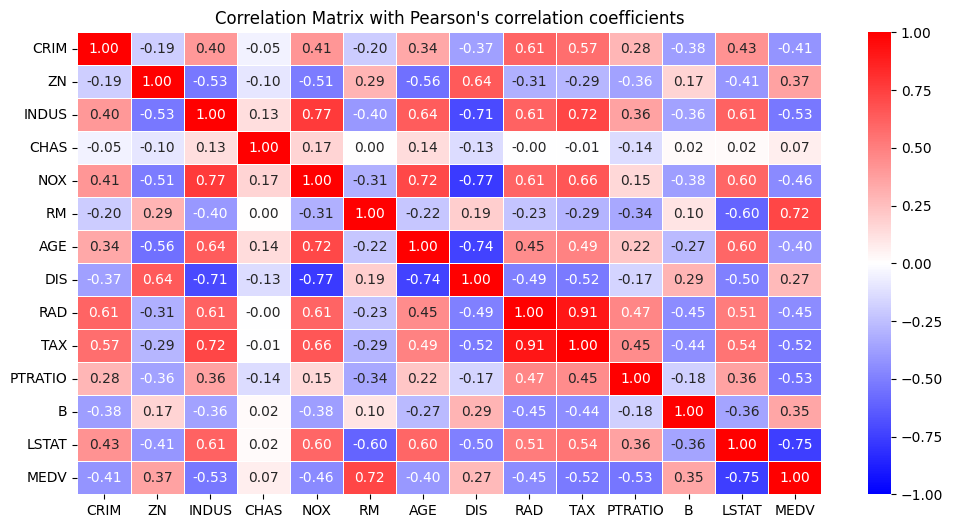

In [6]:
corr_matrix = dtf_train.corr(method="pearson")
plt.figure(figsize=(12,6))
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="bwr", cbar=True, linewidths=0.5)
plt.title("Correlation Matrix with Pearson's correlation coefficients")

According to the correlation matrix, several variables are highly correlated.
I'll try to use the least variables to avoid overfitting.

I'll use Ensemble methods, which use multiple learning algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms alone. A gradient boosting algorithm will be shared: it builds an additive model in a forward stage-wise fashion and in each stage fits a regression tree on the negative gradient of the given loss function.

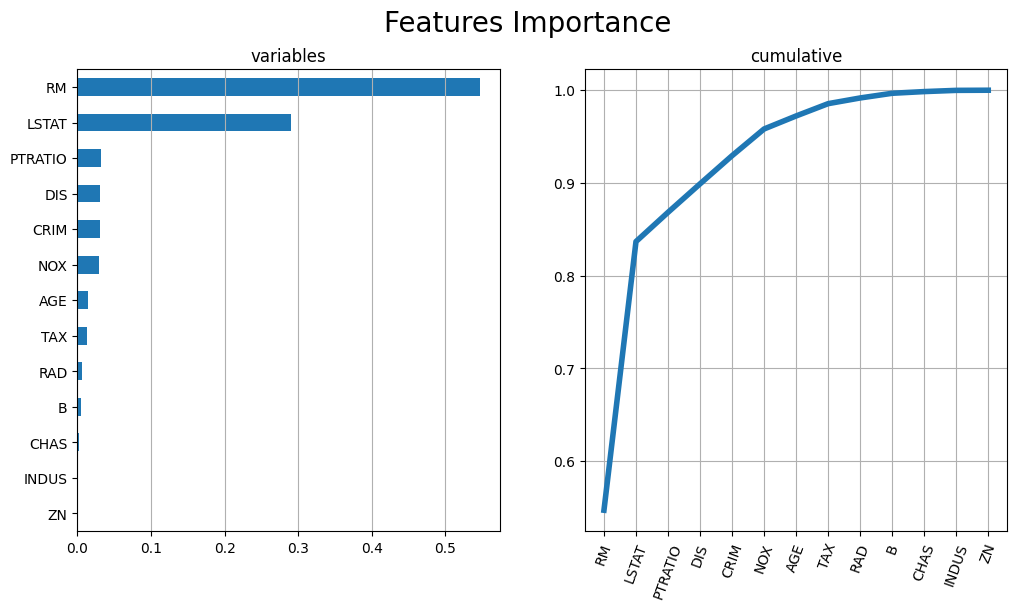

In [7]:
X = dtf_train.drop("MEDV", axis=1).values
y = dtf_train["MEDV"].values
feature_names = dtf_train.drop("MEDV", axis=1).columns.tolist()

# call model
model = ensemble.GradientBoostingRegressor()

# Importance
model.fit(X,y)
importances = model.feature_importances_

## Put in a pandas dtf
dtf_importances = pd.DataFrame({"IMPORTANCE":importances, "VARIABLE":feature_names}).sort_values("IMPORTANCE", ascending=False)
dtf_importances['cumsum'] = dtf_importances['IMPORTANCE'].cumsum(axis=0)
dtf_importances = dtf_importances.set_index("VARIABLE")

# Plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(12,6))
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('variables')
dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')
dtf_importances[["cumsum"]].plot(kind="line", linewidth=4, legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)), xticklabels=dtf_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.show()

The three most important variables are the room number (RM), percentage of lower part of society (LSTAT), and the distance to employment centres (DIS). These three variables cover almost 90% of data variabilities.

I think these three variables could be enough to estimate the median prices and avoid overfitting.

### Linear Regression
- Always use a linear equation.
- Could be multiple, when several equations are added together (BUT the paramters are linear)

### 1. Simple Linear Regression
Predict median prices based on room number values, due to RM has the highest importance.
I'll fit the simple linear regression equation to the original data.

In [8]:
# call model
linear_reg = linear_model.LinearRegression()

# data
X=data[["RM"]]
y=data[["MEDV"]]

# fit Simple Linear Regression equation
model=linear_reg.fit(X,y)

Model has been fitted, the intercept, regression coefficient and the Pearson's correlation coefficient (R2) are:

In [9]:
print("Intercept: ",model.intercept_)
print("Coefficient of Linear Regression Equation: ",model.coef_)
print("Pearson Corr. Coeff. (R2): ",model.score(X,y))

Intercept:  [-34.67062078]
Coefficient of Linear Regression Equation:  [[9.10210898]]
Pearson Corr. Coeff. (R2):  0.48352545599133423


Plot results with formula of simple linear regression:

Text(0.5, 1.0, 'Formula: MEDV = -34.67 + RMx9.10')

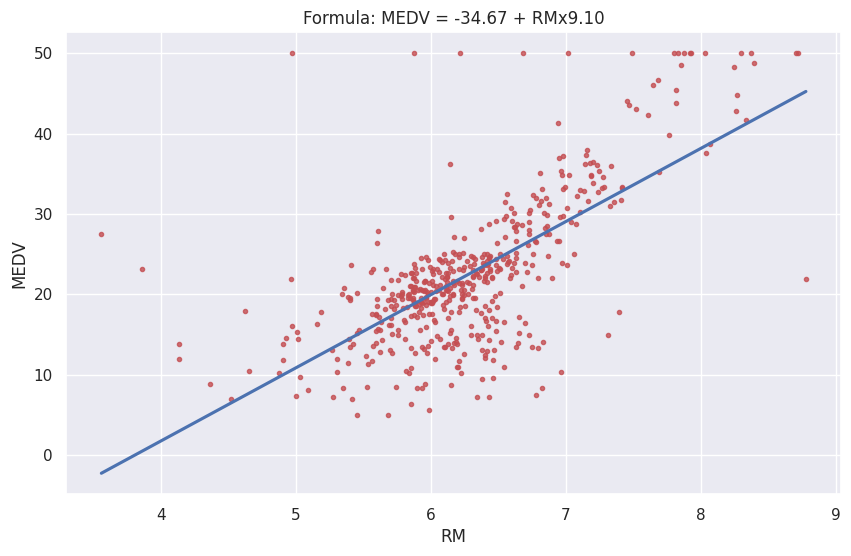

In [10]:
sns.set_theme(rc={"figure.figsize":(10, 6)})
m = sns.regplot(x=X, y=y, ci=None, scatter_kws={"color":"r","s":9})
m.set_title("Formula: MEDV = -34.67 + RMx9.10")

Calculate Mean squared error and Root mean squared error:

In [11]:
# calculate prediction
prediction = model.predict(X)
# MSE and RMSE
MSE = metrics.mean_squared_error(y, prediction)
print("Mean Squared Error: ",MSE)
RMSE=np.sqrt(MSE)
print("Root Mean Squared Error: ",RMSE)

Mean Squared Error:  43.60055177116956
Root Mean Squared Error:  6.603071389222561


Calculate differences between measured and predicted values 

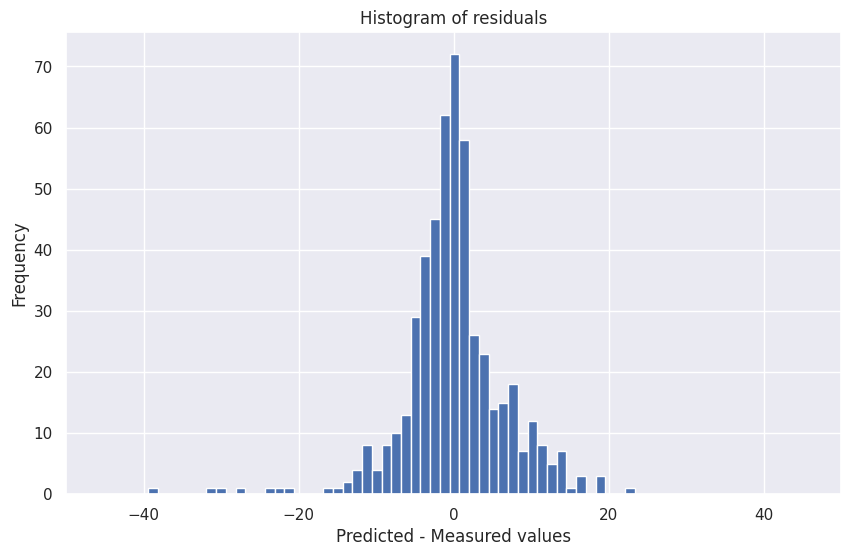

In [12]:
residuals = prediction - y
plt.hist(x=residuals, bins=50)
plt.xlabel('Predicted - Measured values')
plt.ylabel('Frequency')
plt.xlim(-50,50)
plt.title('Histogram of residuals')
plt.show()

#### 2. Multiple Linear Regression
- Uses two or more independent variables to predict the outcome of a dependent variable

I'll use the three most important variables: room number (RM), lower society level rates (LSTAT), distance to employment centres (DIS).

In [13]:
X = data[["RM","LSTAT","DIS"]]
y = data["MEDV"]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X.values, y.values, test_size=0.30, random_state=1)

In this phase I'll create a multiple linear regression model to estimate median prices.

In [14]:
# call model
linear_reg = linear_model.LinearRegression()
# fit the model
multi_linear_model = linear_reg.fit(X_train, y_train)

Let's see the intercept and the coefficient values.

In [15]:
print("Intercepts: ", multi_linear_model.intercept_)
print("Coefficient of Equation: ", multi_linear_model.coef_)

Intercepts:  7.9484174748441845
Coefficient of Equation:  [ 4.04482148 -0.7354036  -0.35804859]


I'll use the K-fold cross validator to split the data into 5 different train, test set with shuffling.

After that I'll use the previously created multiple linear regression model to predict the median prices.

Finally, I'll calculate the Pearson correlation coefficient in case of every data subset.

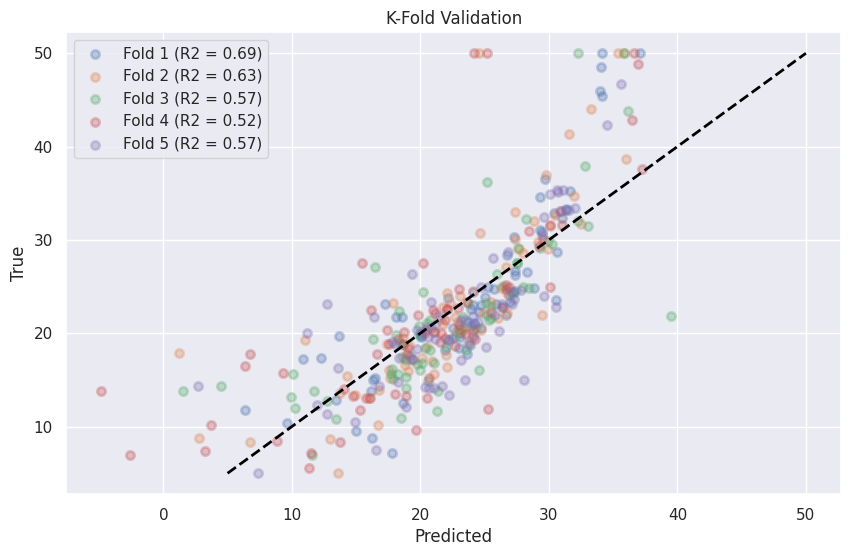

In [16]:
## K fold validation
scores = []
cv = model_selection.KFold(n_splits=5, shuffle=True)
fig = plt.figure()
i = 1
for train, test in cv.split(X_train, y_train):
    prediction = model.fit(X_train[train], y_train[train]).predict(X_train[test])
    true = y_train[test]
    score = metrics.r2_score(true, prediction)
    scores.append(score)
    plt.scatter(prediction, true, lw=2, alpha=0.3, label='Fold %d (R2 = %0.2f)' % (i,score))
    i = i+1
plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], linestyle='--', lw=2, color='black')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('K-Fold Validation')
plt.legend()
plt.show()

In [17]:
print("Train error - RMSE: ", np.sqrt(
    -model_selection.cross_val_score(multi_linear_model,
    X_train,
    y_train,
    cv=10,
    scoring="neg_mean_squared_error")).mean()
)
print("Test error - RMSE: ", np.sqrt(
    -model_selection.cross_val_score(multi_linear_model,
    X_test,
    y_test,
    cv=10,
    scoring="neg_mean_squared_error")).mean()
)

Train error - RMSE:  5.637427770680711
Test error - RMSE:  4.903433763639217


We can conclude that the test dataset error is not higher than the test one, so overfitting is not an issue.

### 3. Principal Component Regression
The technique is based on Principal component analysis (dimension reduction technique). PCR is used for estimating the unknown coefficients in a standard linear regression model.

I'll use the PCA and after that I'll create a regression model from the PCA results.

In [18]:
# create test, train dataset
X = data.drop(["MEDV"], axis=1)
y = data["MEDV"]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.30, random_state=1)
# print dimensions
print("X_train",X_train.shape)
print("X_test",X_test.shape)
print("y_train",y_train.shape)
print("y_test",y_test.shape)

X_train (354, 13)
X_test (152, 13)
y_train (354,)
y_test (152,)


Principal component analysis (PCA) reduces the input dimension to predefined number of variables, which has the highest variance.
However, if n is not defined, it will keep the original feature number.

In [19]:
pca = decomposition.PCA()

X_reduce_train = pca.fit_transform(preprocessing.scale(X_train))
X_reduce_test = pca.fit_transform(preprocessing.scale(X_test))
# X_reduce_train[0:1,:]
print(X_reduce_train[0:1, :])

[[-0.74020474 -0.25772248 -1.24562422 -0.87182035 -0.14514554  0.56596712
   0.04461017  0.12306196  0.082379    0.5529205  -0.41805738  0.38013874
   0.09292103]]


I'll calculate the variable importance from the variance point of view.

In [20]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3) * 100)[0:10]

array([45.5, 58.1, 67.3, 74.3, 80.1, 85.5, 89.6, 92.5, 94.8, 96.5])

The first variable has variance rate : 47.9, the first and second (together) have variance rate : 58.7.
We can see that when the variable number increases, the variance rate also increases.  

In [21]:
# model
linear_regression = linear_model.LinearRegression()
# pcr_model
pcr_model = linear_regression.fit(X_reduce_train, y_train)

I'll print the intercept and the coefficient values:

In [22]:
print("Intercept: ", pcr_model.intercept_)
print("Coefficients: ", pcr_model.coef_)

Intercept:  22.339830508474574
Coefficients:  [-2.22948212 -0.97112432  3.59115177 -1.06933733 -2.02292452 -0.33532128
  0.55668841  1.510547   -0.0061447   1.61711294  2.05288504 -3.2011519
 -3.63744976]


I'll apply the model to predict test data.

In [23]:
# calculate predicted values
y_pred = pcr_model.predict(X_reduce_train)
y_pred_t = pcr_model.predict(X_reduce_test)
# calculate Pearson's correlation coefficient
print("Pearson's corr. coeff.: ", metrics.r2_score(y_train, y_pred))
print("Train Error - RMSE: ",np.sqrt(metrics.mean_squared_error(y_pred,y_train)))
print("Test Error - RMSE: ",np.sqrt(metrics.mean_squared_error(y_pred_t,y_test)))

Pearson's corr. coeff.:  0.7103879080674731
Train Error - RMSE:  4.849055005805464
Test Error - RMSE:  8.329860116651343


What happens if we use only fewer features?
I'll calculate the root mean squared error values if we rely on fewer variables.

In [24]:
RMSE=[]

for i in np.arange(1, X_reduce_train.shape[1] + 1):
    score=np.sqrt(-1 * model_selection.cross_val_score(linear_regression,
                                                    X_reduce_train[:,:i],
                                                    y_train.ravel(),
                                                    scoring="neg_mean_squared_error").mean())
    RMSE.append(score)

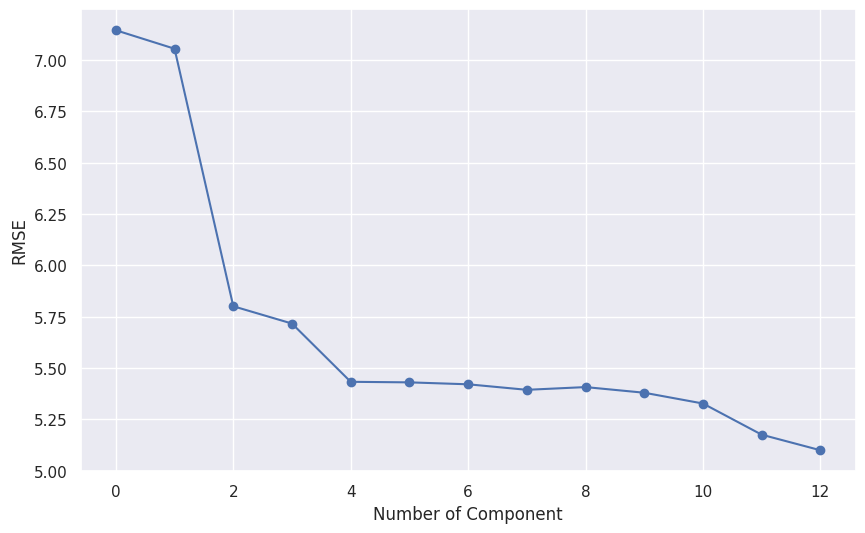

In [25]:
plt.plot(RMSE,"-o")
plt.xlabel("Number of Component")
plt.ylabel("RMSE")
plt.show()

We can conclude that we can reach the smallest RMSE if we relay on all variables, which is not an issue in case of 500 observations.
However, if we have millions of observations it could make a difference. I think the optimal feature number could be 4, because the RMSE only decreases slightly after that component number.

### 4. Ridge Regression

- Ridge regression is a method of estimating the coefficients of multiple-regression models in scenarios where the independent variables are highly correlated. (like in this case)
- Ridge regression adds the “squared magnitude” of the coefficient as the penalty term to the loss function, Ridge regression is based on the L2 norm.



In [26]:
ridge_model = linear_model.Ridge(alpha=0.1).fit(X_train, y_train)
# alpha = 0 means Linear Regression, default value is 0.1. 
ridge_model.coef_

array([-9.70157234e-02,  6.09902403e-02,  5.09494246e-02,  2.40921031e+00,
       -1.96930765e+01,  2.81550770e+00,  2.08872393e-03, -1.49077685e+00,
        3.03255636e-01, -1.14498629e-02, -9.84170523e-01,  6.56381793e-03,
       -5.70625285e-01])

I'll predict the test dataset.

In [27]:
y_pred = ridge_model.predict(X_test)
print("Test dataset - RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Test dataset - RMSE:  4.438040089027376


The goal of model tuning or hyperparameter tuning is to find the most optimal hyperparameter (in our case the alpha value).

I'll generate a linear alpha series, which covers the whole sample space.

In [28]:
alphas = 10**np.linspace(10, -2, 100) * 0.5
alphas[0:5]

array([5.00000000e+09, 3.78231664e+09, 2.86118383e+09, 2.16438064e+09,
       1.63727458e+09])

Finally, I'll use the built-in cross validator to find the optimal alpha value from the list, the scoring metric will be the RMSE value. 

In [29]:
# Ridge cross validator
ridge_cv = linear_model.RidgeCV(alphas=alphas, scoring="neg_mean_squared_error", normalize=True)
# print the optimal alpha value
print("The optimal alpha value is: ", ridge_cv.fit(X_train, y_train).alpha_)

The optimal alpha value is:  0.01155064850041579


/home/znagy2/ds_az/ds_az_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alphas to: original_alphas * n_samples. 
  warnings.warn(


### 5. LASSO Regression

- Lasso is an acronym for least absolute shrinkage and selection operator, and lasso regression adds the “absolute value of magnitude” of the coefficient as a penalty term to the loss function.
- It relies on the L1 norm, which is more robust than L2 norm based Ridge regression.

In [30]:
# fit model to train data
lasso_model = linear_model.Lasso(alpha=0.1).fit(X_train,y_train)
# model coefficients
lasso_model.coef_

array([-0.07989188,  0.06378989, -0.02637228,  0.89488532, -0.        ,
        2.78861531, -0.00981237, -1.15727222,  0.26641308, -0.0140787 ,
       -0.75496628,  0.0077946 , -0.61309592])

In [31]:
# make prediction with LASSO model
y_pred = lasso_model.predict(X_test)
# print evaluation metric
print("Test data - RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Test data - RMSE:  4.497189901120615


Similar to the Ridge model, the LASSO has a hyperparameter, the alpha, so I'll tune that one.
To solve this issue, I'll use the built-in Lasso cross validator.

In [32]:
lasso_cv = linear_model.LassoCV(alphas=None, cv=10, max_iter=10000, normalize=True)
# get the optimal alpha
lasso_cv.fit(X_train,y_train).alpha_

/home/znagy2/ds_az/ds_az_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


0.0010814077253430154

### 6. Elastic Net Regression
- Mixed of L1 (Lasso) and L2 (Ridge) penaltization.
- Elastic Net first emerged as a result of critique on Lasso, whose variable selection can be too dependent on data and thus unstable.
- The solution is to combine the penalties of Ridge regression and lasso to get the best of both worlds.


In [33]:
elNet_model = linear_model.ElasticNet().fit(X_train, y_train)

I'll print the intercept and the equation coefficients.

In [34]:
print("Intercept: ", elNet_model.intercept_)
print("Coefficient of Equation: ", elNet_model.coef_)

Intercept:  43.50488736371214
Coefficient of Equation:  [-0.06892062  0.06229229 -0.          0.         -0.          0.60621493
  0.01506499 -0.69022698  0.26553588 -0.01387045 -0.71551352  0.00639852
 -0.75468341]


In [35]:
y_pred = elNet_model.predict(X_test)
print("Test data - RMSE: ",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("Test data - R2 Score: ", metrics.r2_score(y_test, y_pred))

Test data - RMSE:  5.245299910848632
Test data - R2 Score:  0.6998164298907721


Finally, I'll tune hyperparameters:
- alpha parameter (similar to LASSO regression --> 0 means Linear regression)
- L1 ration (the L1 weight in the penaltization --> 0 means Ridge regression)

In [36]:
elNet_model_CV = linear_model.ElasticNetCV(cv=10,random_state=0).fit(X_train,y_train)
print("Optimal alpha: ", elNet_model_CV.alpha_)
print("Optimal L1 ratio: ", elNet_model_CV.l1_ratio_)

Optimal alpha:  1.3415132145935076
Optimal L1 ratio:  0.5


### 7. Support Vector MAchine (Regression)

Originally, the SVM classification was extended to solve regression problems.
I'll ficus on the room number and the median prices.

In [37]:
X = data[["RM"]]
y = data[["MEDV"]]
X_train, X_test, y_train, y_test= model_selection.train_test_split(X, y, test_size=0.30, random_state=1)

I'll create and fit the SVM model...

In [38]:
svr_model = svm.LinearSVR(C=0.01, fit_intercept=True, epsilon=5).fit(X_train, np.ravel(y_train))

I'll print the intercept and the equation ceofficient:

In [39]:
print("Intercept: ", svr_model.intercept_)
print("Coefficient of Equation: ", svr_model.coef_)

Intercept:  [0.39427542]
Coefficient of Equation:  [3.0970117]


I'll check the results and compare model prediction with data.

In [40]:
# predict values
y_pred = svr_model.predict(X_test)
# print performance metrics
print("Test data - MSE: ", metrics.mean_squared_error(y_test, y_pred))
print("Test data - RMSE: ",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Test data - MSE:  71.24652653315704
Test data - RMSE:  8.440765755140765


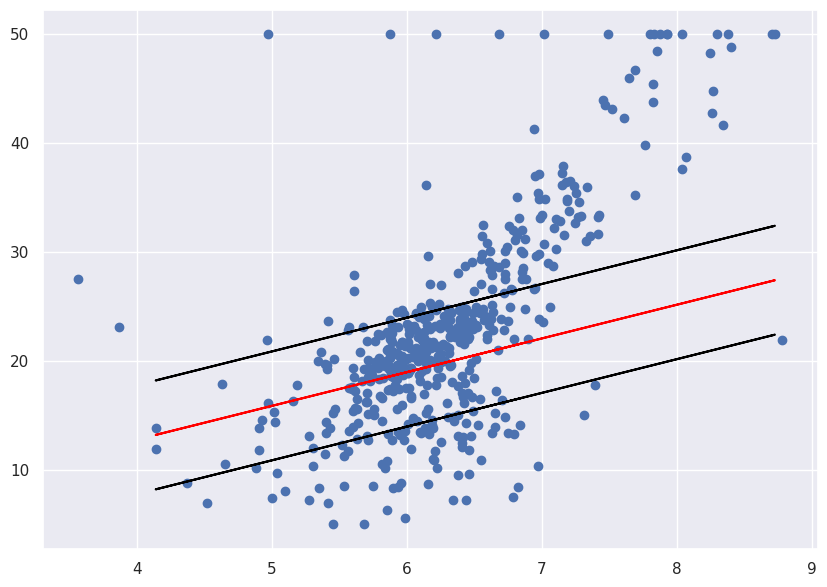

In [41]:
plt.figure(figsize=(10,7))
plt.scatter(x=data["RM"],y=data["MEDV"])
plt.plot(X_test,y_pred, color="red")
plt.plot(X_test,y_pred+5, color="black")
plt.plot(X_test,y_pred-5, color="black")
plt.show()

We can agree on that the first results are not so impressive. I'll tune the hyperparameters to deliver a better model.

In [42]:
# create hyperparameter space
grid = {
    "C":np.linspace(0.01, 10),
    "epsilon":np.linspace(0.01, 10)
}

In [43]:
# call SVM model
svr_gridSearch = svm.LinearSVR(fit_intercept=True, max_iter=100000)
# call GridSearch cross validator 
grid_svr = model_selection.GridSearchCV(svr_gridSearch, grid, scoring='neg_mean_absolute_error', cv=5)
# train the model
grid_svr.fit(X_train, np.ravel(y_train))

GridSearchCV(cv=5, estimator=LinearSVR(max_iter=100000),
             param_grid={'C': array([ 0.01      ,  0.21387755,  0.4177551 ,  0.62163265,  0.8255102 ,
        1.02938776,  1.23326531,  1.43714286,  1.64102041,  1.84489796,
        2.04877551,  2.25265306,  2.45653061,  2.66040816,  2.86428571,
        3.06816327,  3.27204082,  3.47591837,  3.67979592,  3.88367347,
        4.08755102,  4.29142857,  4.49530612,  4.69918367,  4.90306122,
        5.106...
        4.08755102,  4.29142857,  4.49530612,  4.69918367,  4.90306122,
        5.10693878,  5.31081633,  5.51469388,  5.71857143,  5.92244898,
        6.12632653,  6.33020408,  6.53408163,  6.73795918,  6.94183673,
        7.14571429,  7.34959184,  7.55346939,  7.75734694,  7.96122449,
        8.16510204,  8.36897959,  8.57285714,  8.77673469,  8.98061224,
        9.1844898 ,  9.38836735,  9.5922449 ,  9.79612245, 10.        ])},
             scoring='neg_mean_absolute_error')

I'll get and use the best Estimator.

In [44]:
best_SVR = grid_svr.best_estimator_
best_SVR.fit(X_train, np.ravel(y_train))

LinearSVR(C=10.0, epsilon=0.41775510204081634, max_iter=100000)

I make a newer prediction and visualize the results.

In [45]:
y_pred = best_SVR.predict(X_test)
print("Test data - MSE: ", metrics.mean_squared_error(y_test, y_pred))
print("Test data - RMSE: ",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Test data - MSE:  36.38428409462394
Test data - RMSE:  6.031938668009145


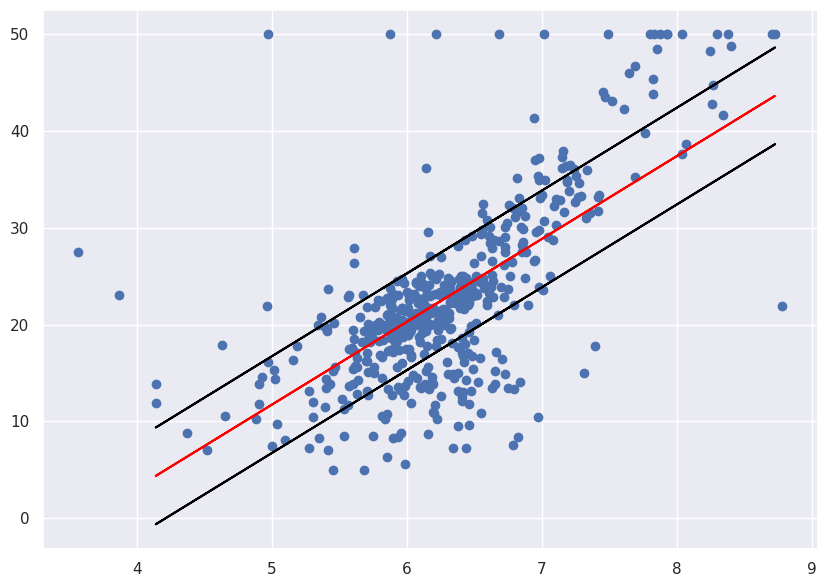

In [46]:
plt.figure(figsize=(10,7))
plt.scatter(x=data["RM"], y=data["MEDV"])
plt.plot(X_test,y_pred, color="red")
plt.plot(X_test,y_pred+5, color="black")
plt.plot(X_test,y_pred-5, color="black")
plt.show()

The results look like much better after the hyperparameter tuning.